## MultiClass classification of emotion on tweets data using Bert pre-trained model

Data Link--> https://www.kaggle.com/datasets/parulpandey/emotion-dataset

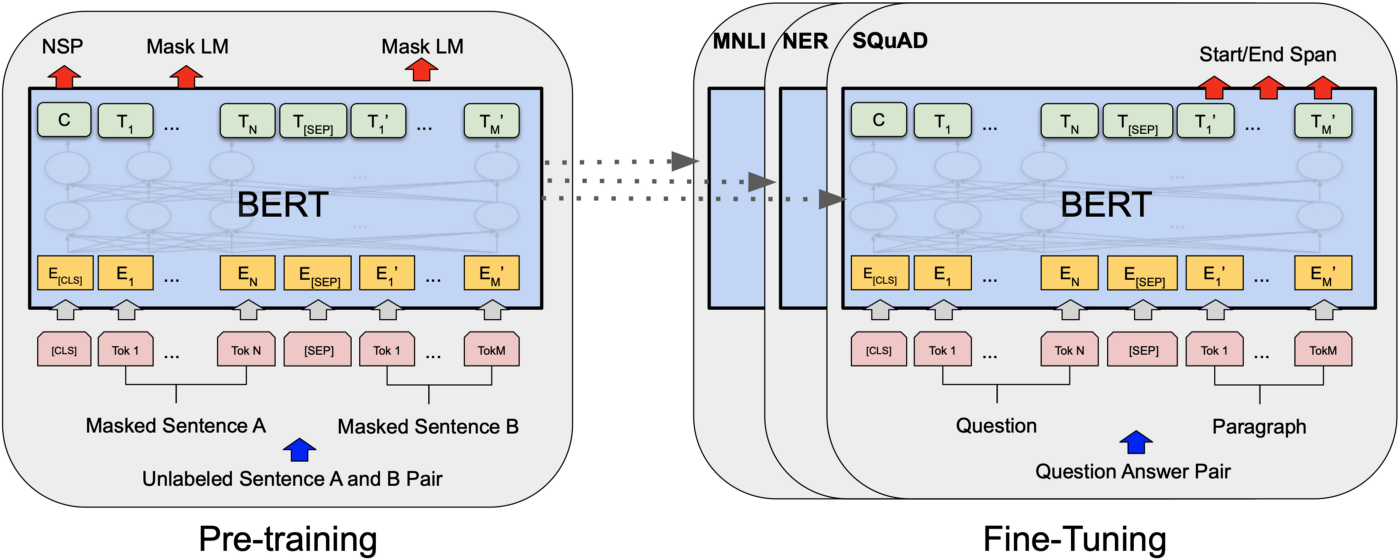 

## Problem statement:

   A dataset of English Twitter messages with six emotions: anger, fear, joy, love, sadness, and surprise.
In the era of a customer-focused industry, companies are coming up with new ways to understand their consumers. Detecting emotions accurately from the reviews, chats, tweets, blogs, posts, etc. is one such method without explicitly asking the customers. With the advent of new algorithms and increasing computing power, Natural Language Processing (NLP) has enabled us to detect emotions from written text & take action accordingly.
   
   Here, We have to detect the emotions of customers based on the tweets by using state-of-the-art architectures to solve the probelem and predict accurately.

   ## Annotations of different emotions:
   
   ## Anger : 0
   ## Fear : 1 
   ## Joy : 2 
   ## Love : 3 
   ## Sadness : 4
   ## Surprise : 5

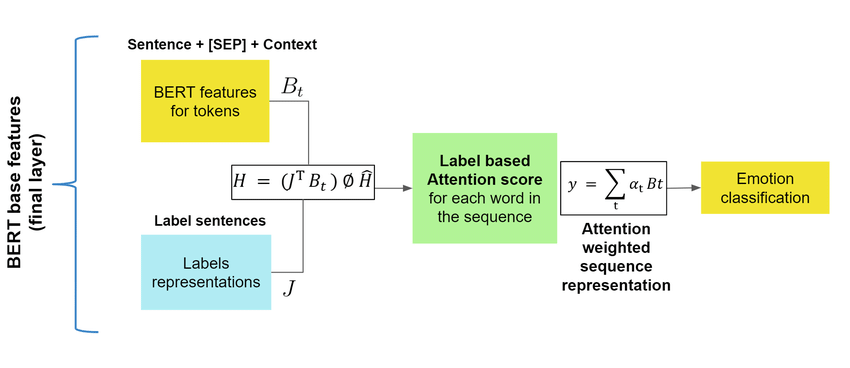 

## Table of contents
 
1. ## Importing and installing required libraries
2. ## Doing some text preprocessing
3. ## Now let's load the model
4. ## Model fitting and evaluation
5. ## Prediction part
6. ## Prediction on custom text

# 1. Importing and Installing required libraries

In [1]:
!pip install text_hammer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 309.6 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.1
    Uninstalling beautifulsoup4-4.11.1:
      Successfully uninstalled beautifulsoup4-4.11.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompat

In [2]:
import pandas as pd
import numpy as np
import text_hammer as th
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer,TFBertModel
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False # if autocompletion doesnot work in kaggle notebook | hit tab

2022-09-07 15:28:28.827454: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
# importing the dataset 
df_train = pd.read_csv('../input/emotion-dataset/training.csv')
df_test = pd.read_csv('../input/emotion-dataset/test.csv')
df_val=pd.read_csv('../input/emotion-dataset/validation.csv')

In [4]:
df_full = pd.concat([df_train,df_test,df_val], axis = 0)
df_full

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
1995,im having ssa examination tomorrow in the morn...,0
1996,i constantly worry about their fight against n...,1
1997,i feel its important to share this info for th...,1
1998,i truly feel that if you are passionate enough...,1


# 2. Doing some text preprocessing 

In [5]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
 
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
 
    return(df)

In [6]:
df_cleaned = text_preprocessing(df_full,'text')

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [7]:
df_cleaned = df_cleaned.copy()

In [8]:
df_cleaned['num_words'] = df_cleaned['text'].apply(lambda x:len(x.split()))

In [9]:
# changing the data type to the category to encode into codes 
df_cleaned['label'] = df_cleaned['label'].astype('category')

In [10]:
df_cleaned['label']

0       0
1       0
2       3
3       2
4       3
       ..
1995    0
1996    1
1997    1
1998    1
1999    1
Name: label, Length: 20000, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

In [11]:
df_cleaned['label'].cat.codes

0       0
1       0
2       3
3       2
4       3
       ..
1995    0
1996    1
1997    1
1998    1
1999    1
Length: 20000, dtype: int8

In [12]:
encoded_dict  = {'anger':0,'fear':1, 'joy':2, 'love':3, 'sadness':4, 'surprise':5}

In [13]:
df_cleaned.num_words.max()

66

In [14]:
data_train,data_test = train_test_split(df_cleaned, test_size = 0.3, random_state = 42, stratify = df_cleaned['label'])

In [15]:
data_train.shape

(14000, 3)

In [16]:
data_test.shape

(6000, 3)

In [17]:
to_categorical(data_train['label'])

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

# 3. Now lets load the model 

In [18]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [19]:
# for saving model locally and we can load it later on 
tokenizer.save_pretrained('bert-tokenizer')
bert.save_pretrained('bert-model')

In [20]:
shutil.make_archive('bert-tokenizer', 'zip', 'bert-tokenizer')
shutil.make_archive('bert-model','zip','bert-model')

'/kaggle/working/bert-model.zip'

In [21]:
tokenizer('I will be kaggle grandmaster')

{'input_ids': [101, 146, 1209, 1129, 24181, 25186, 5372, 6532, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [22]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
x_train = tokenizer(
    text=data_train['text'].tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


x_test = tokenizer(
    text=data_test['text'].tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [23]:
x_test['input_ids']

<tf.Tensor: shape=(6000, 70), dtype=int32, numpy=
array([[ 101,  178, 1243, ...,    0,    0,    0],
       [ 101,  178, 1631, ...,    0,    0,    0],
       [ 101,  178, 2810, ...,    0,    0,    0],
       ...,
       [ 101,  178, 1838, ...,    0,    0,    0],
       [ 101,  178, 1238, ...,    0,    0,    0],
       [ 101,  178, 4534, ...,    0,    0,    0]], dtype=int32)>

In [24]:
max_len = 70
 
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 means pooler_output)
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(6,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [25]:
optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 70)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 70)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           tf_bert_model[0][0]          

In [27]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

# 4. Model fitting and then evaluation

In [28]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = to_categorical(data_train['label']),
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(data_test['label'])
    ),
  epochs=1,
    batch_size=36
)

2022-09-07 15:30:25.613943: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


389/389 [==============================] - 6722s 17s/step - loss: 0.5745 - balanced_accuracy: 0.7984 - val_loss: 0.2000 - val_balanced_accuracy: 0.9275


# 5.Prediction Part

In [29]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

In [30]:
predicted_raw[0]

array([0.02990153, 0.9908037 , 0.23566514, 0.02250284, 0.0631406 ,
       0.1623123 ], dtype=float32)

In [31]:
y_predicted = np.argmax(predicted_raw, axis = 1)
y_predicted

array([1, 1, 1, ..., 0, 3, 4])

In [32]:
data_test['label']

2950     1
11631    1
8685     1
10305    0
11829    0
        ..
2666     1
6556     3
14591    0
1748     3
4950     4
Name: label, Length: 6000, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

In [43]:
accuracy_score(data_test['label'],y_predicted)

0.9275

In [33]:
print(classification_report(data_test['label'], y_predicted))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1739
           1       0.95      0.94      0.95      2028
           2       0.82      0.88      0.85       492
           3       0.91      0.94      0.93       813
           4       0.87      0.92      0.89       712
           5       0.87      0.77      0.82       216

    accuracy                           0.93      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.93      0.93      0.93      6000



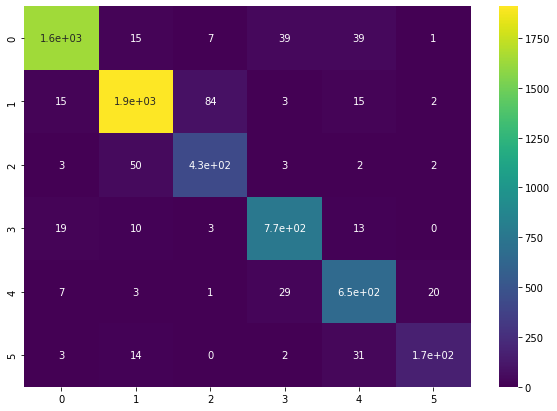

In [34]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(data_test['label'],y_predicted),annot=True,cmap='viridis')
plt.show()

# 5. Prediction on custom text

In [40]:
texts = input(str('input the text'))

x_val = tokenizer(
    text=texts,
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True) 
validation = model.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})*100
validation

input the text Movie is very bad, I want my money back.


array([[72.79686 , 28.849524,  8.209145, 39.88458 , 19.101107, 13.449428]],
      dtype=float32)

In [41]:
for key , value in zip(encoded_dict.keys(),validation[0]):
    print(key,value)

anger 72.79686
fear 28.849524
joy 8.209145
love 39.88458
sadness 19.101107
surprise 13.449428


# Thanking you